# Example of ORA and GSEA

We first run the same steps as in the previous notebook on multiple testing.

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    ![ ! -f "dsbook/README.md" ] && git clone https://github.com/statisticalbiotechnology/dsbook.git
    my_path = "dsbook/dsbook/common/"
else:
    my_path = "../common/"
sys.path.append(my_path) # Read local modules for tcga access and qvalue calculations
import load_tcga as tcga
import qvalue 

brca = tcga.get_expression_data(my_path + "../data/brca_tcga_pub2015.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/brca_tcga_pub2015.tar.gz',"data_mrna_seq_v2_rsem.txt")
brca_clin = tcga.get_clinical_data(my_path + "../data/brca_tcga_pub2015.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)
brca_clin.loc["3N"]= (brca_clin.loc["PR_STATUS_BY_IHC"]=="Negative") & (brca_clin.loc["ER_STATUS_BY_IHC"]=="Negative") & (brca_clin.loc["IHC_HER2"]=="Negative")
tripple_negative_bool = (brca_clin.loc["3N"] == True)

def get_significance_two_groups(row):
    log_fold_change = row[tripple_negative_bool].mean() - row[~tripple_negative_bool].mean()
    p = ttest_ind(row[tripple_negative_bool],row[~tripple_negative_bool],equal_var=False)[1]
    return [p,-np.log10(p),log_fold_change]

pvalues = brca.apply(get_significance_two_groups,axis=1,result_type="expand")
pvalues.rename(columns = {list(pvalues)[0]: 'p', list(pvalues)[1]: '-log_p', list(pvalues)[2]: 'log_FC'}, inplace = True)
qvalues = qvalue.qvalues(pvalues)

File extracted to ../data/brca_tcga_pub2015
File extracted to ../data/brca_tcga_pub2015


If we investigate a Volcano plot of the tripple negative cancers vs. the other cancers, we see an large number of both up and down regulated genes. We will in this note book ecamine if there are common patterns in the up and down regulation. 

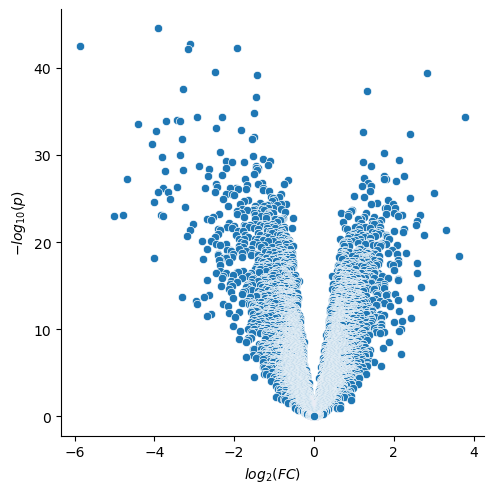

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(data=qvalues,x="log_FC",y="-log_p")
plt.xlabel("$log_2(FC)$")
plt.ylabel("$-log_{10}(p)$")
plt.show()

### Over-representation analysis

We use the [gseapy](https://gseapy.readthedocs.io/) module to run an overrepresentation analysis. The module is unfortunately not implementing pathway analysis itself. It instead call a remote webserver[Enrichr](http://amp.pharm.mssm.edu/Enrichr/).  

In the analysis here we use the [KEGG](https://www.genome.jp/kegg/) database's definition of metabolomic pathways. This choice can easily be changed to other databases such as GO.

Here we select to use the $q$ values below $10^{-15}$ as an input. 

In [4]:
import gseapy as gp

pathway_db=['KEGG_2019_Human']
background=set(qvalues.index)
gene_list = list(qvalues.loc[qvalues["q"]<1e-15,"q"].index)

output_enrichr=pd.DataFrame()
enr=gp.enrichr(
                gene_list=gene_list,
                gene_sets=pathway_db,
                background=background,
                outdir = None
            )


We clean up the results a bit by only keeping some of the resulting metics. We also multiple hypothesis correct our results, and list the terms with a FDR less than 5%.

In [5]:
kegg_enr = enr.results[["P-value","Term"]].rename(columns={"P-value": "p"})
kegg_enr = qvalue.qvalues(kegg_enr)
kegg_enr.loc[kegg_enr["q"]<0.20]

,p,Term,q
0,1.238286e-07,Cell cycle,0.000033
1,1.057869e-03,"Alanine, aspartate and glutamate metabolism",0.141804


The analysis seem to find overrepresentation of relatively few pathways, particularly given the significance of the differences between case and controll on transcript level. 

## Geneset Enrichment analysis

Subsequently we us pygsea to perform a geneset enricment analysis (GSEA).


In [6]:
classes = ["TrippleNeg" if tripple_negative_bool[sample_name] else "Respond" for sample_name in brca.columns]
gs_res = gp.gsea(data=brca, 
                 gene_sets='KEGG_2016', 
                 # gene_sets='Reactome_2013',
                 cls=classes, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 no_plot=True, # Skip plotting
                 method='signal_to_noise',
                 # method='t_test',
                 processes=4, # Number of allowed parallel processes
                 format='png',
                 ascending=True,
                max_size=20000)


/tmp/ipykernel_657596/3013437965.py:2: DeprecationWarning: processes is deprecated; use threads
  gs_res = gp.gsea(data=brca,
2024-11-18 09:19:38,791 [WARNING] Found duplicated gene names, values averaged by gene names!


The pygsea module's fdr calculation seems to be broken, and we hence remake the significance calculations ourselves.

In [7]:
gs_res.res2d

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Ribosome biogenesis in eukaryotes Homo sapiens...,-0.573494,-2.031795,0.021277,0.048163,0.03,46/71,26.85%,DKC1;CIRH1A;GTPBP4;RBM28;RPP25;RIOK1;NOP58;POP...
1,gsea,Cell cycle Homo sapiens hsa04110,-0.505168,-1.828244,0.02,0.445508,0.29,59/119,21.45%,CCNE1;CDC20;E2F3;MCM7;MCM5;TTK;CDC25A;CHEK1;OR...
2,gsea,Peroxisome Homo sapiens hsa04146,0.458212,1.735755,0.061224,1.0,0.44,30/70,26.07%,NUDT12;HSD17B4;PEX12;ACOX2;CROT;SLC27A2;PEX11A...
3,gsea,RNA transport Homo sapiens hsa03013,-0.461384,-1.718459,0.040816,0.754554,0.51,75/149,29.20%,NUP93;MAGOH;THOC5;XPO5;UPF3B;RPP25;PABPC4;POP1...
4,gsea,DNA replication Homo sapiens hsa03030,-0.62573,-1.706424,0.037736,0.63816,0.57,28/35,29.04%,MCM7;MCM5;RNASEH1;RFC4;PRIM2;MCM3;FEN1;RFC2;MC...
...,...,...,...,...,...,...,...,...,...,...
253,gsea,Steroid biosynthesis Homo sapiens hsa00100,-0.192438,-0.480634,1.0,1.0,1.0,17/17,91.21%,DHCR7;EBP;SOAT1;NSDHL;CYP27B1;LSS;SQLE;FDFT1;M...
254,gsea,Non-alcoholic fatty liver disease (NAFLD) Homo...,0.128179,0.476261,1.0,0.986453,1.0,129/129,99.31%,XBP1;PRKAG1;PRKAB1;IKBKB;COX6C;IRS1;MAPK9;RXRA...
255,gsea,Oxidative phosphorylation Homo sapiens hsa00190,-0.169679,-0.439525,0.925926,1.0,1.0,55/108,46.96%,ATP6V1C2;UQCRHL;UQCRH;ATP6V1E2;NDUFS5;NDUFA9;A...
256,gsea,Olfactory transduction Homo sapiens hsa04740,-0.152696,-0.42714,1.0,1.0,1.0,12/23,44.71%,ARRB2;ADCY3;RGS2;NCALD;CALM2;CAMK2G;CAMK2D;GNA...


In [8]:
import qvalue
gs_res.res2d.sort_values(by=["NOM p-val"],inplace=True)
out = qvalue.qvalues(gs_res.res2d,"NOM p-val").drop(["FDR q-val","FWER p-val"], axis='columns')

We list the 2 topscoring pathways.

In [9]:
out.loc[out["q"]<0.20]

,Name,Term,ES,NES,NOM p-val,Tag %,Gene %,Lead_genes,q
11,gsea,Vasopressin-regulated water reabsorption Homo ...,0.477173,1.574705,0.0,22/37,32.90%,DCTN4;ADCY9;RAB5B;CREB3L4;ADCY6;RAB5C;CREB3L1;...,0.0
9,gsea,Circadian rhythm Homo sapiens hsa04710,0.53594,1.597341,0.0,11/28,14.07%,SKP1;BHLHE40;BTRC;PER2;CRY2;PRKAG1;PRKAB1;RORC...,0.0
6,gsea,Pathogenic Escherichia coli infection Homo sap...,-0.51859,-1.666679,0.0,30/47,29.60%,NCK2;TUBB;TUBB6;TUBA1C;ARPC5;NCL;TUBB3;TUBA1B;...,0.0


We display some detailed plots of the best scoring pathway using gseapy's plotting routines.

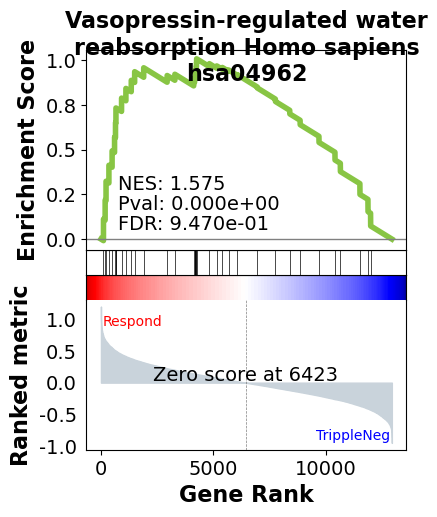

In [10]:
from gseapy.plot import gseaplot, heatmap
terms = gs_res.res2d.Term
axs = gs_res.plot(terms=terms[11]) # v1.0.5

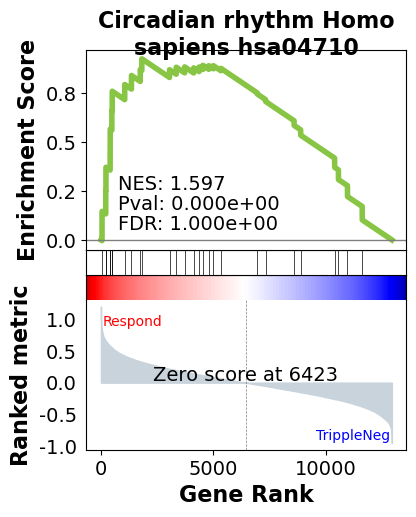

In [11]:
axs = gs_res.plot(terms=terms[9]) 

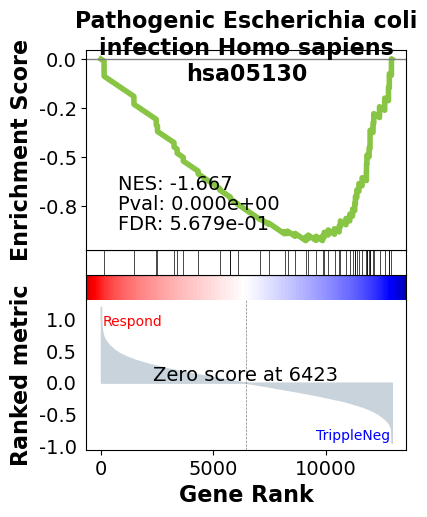

In [12]:
axs = gs_res.plot(terms=terms[6]) 